# Ejemplo completo para un problema de regresión usando sci-kitlearn

El siguiente ejemplo presenta las etapas básicas de un proyecto de analítica de datos en una tarea de regresión, orientadas a:

- Preproceso de atributos con campos vacios y tipo texto.
- Entrenamiento y selección de un modelo de regresión bajo una estrategia de validación cruzada.
- La utilización de diccionarios para la sintonización de hiperparámetros.
-Se ilustra también la creación de clases (objetos) propios compatibles con la clase pipeline de sci-kitlearn.

**Base de datos utilizada**: [FIFA 2019 - Kaggle](https://www.kaggle.com/datasets/devansodariya/football-fifa-2019-dataset).

In [1]:
#cargar datos desde drive acceso libre
FILEID = "15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

--2024-12-12 21:25:08--  https://docs.google.com/uc?export=download&confirm=&id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe
Resolving docs.google.com (docs.google.com)... 108.177.12.138, 108.177.12.102, 108.177.12.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.12.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe&export=download [following]
--2024-12-12 21:25:08--  https://drive.usercontent.google.com/download?id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.107.132, 2607:f8b0:400c:c32::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4039371 (3.9M) [application/octet-stream]
Saving to: ‘codigos.zip’

codigos.zip         100%[===================>]   3.85M  --.-K

# Lectura de la base de datos con Pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#librerias para proceso
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline
csv_path = 'Main_Fifa/datos/data.csv' #directorio de la base de datos en disco de colaboratory según archivo cargado

Xdata = pd.read_csv(csv_path)#leer archivo csv

col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag',
           'Club Logo','Loaned From'] #variables a descartar - no contienen información relevante
Xdata.drop(columns = col_drop, inplace = True)
Xdata.head()

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


# Identificar tipos de variables, campos perdidos y preproceso básico a realizar

In [3]:
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       18207 non-null  int64  
 1   Nationality               18207 non-null  object 
 2   Overall                   18207 non-null  int64  
 3   Potential                 18207 non-null  int64  
 4   Club                      17966 non-null  object 
 5   Value                     18207 non-null  object 
 6   Wage                      18207 non-null  object 
 7   Special                   18207 non-null  int64  
 8   Preferred Foot            18159 non-null  object 
 9   International Reputation  18159 non-null  float64
 10  Weak Foot                 18159 non-null  float64
 11  Skill Moves               18159 non-null  float64
 12  Work Rate                 18159 non-null  object 
 13  Body Type                 18159 non-null  object 
 14  Real F

## Se presentan atributos tipo int, float y texto, algunos de ellos con datos perdidos.

# Partición en conjunto de training y testing.

## Tips básicos para escoger la estrategia de validación:

- Para $N\geq 5000$ se sugiere realizar entrenamiento hold-out, generando grupos de entrenamiento, validación y evaluación. Los conjuntos de entrenamiento y validación se pueden utilizar para realizar validación cruzada de 10 o 5 folds para determinar el mejor modelo y sus hiperparámetros.

- No obstante, si la cantidad de datos es muy grande, generalmente se utiliza un único conjunto de entrenamiento y un único conjunto de validación, e.g., modelos de deep learning generalmente utilizan esta estrategia por la gran cantidad de datos disponible.

**HoldOut con única partición de entrenamiento, validación y evaluación (training, validation, testing)**

![HoldOut](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/3_Intro_Sklearn_Regresion/HoldOut.png?raw=1)


**HoldOut utilizando validación cruzada para definir varios conjuntos de entrenamiento y validación en la búsqueda del mejor modelo con evaluación final en un único conjunto de testing**

![grid_search_cross_validation](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/3_Intro_Sklearn_Regresion/crossvalidation.png?raw=1)

- Se sugiere para $ 30 <N <5000$ realizar validación cruzada o validación cruzada anidad k folds (generalmente se trabaja con k=10 o k = 5), y reportar el desempeño promedio en el conjunto de test a lo largo de las rotaciones.

- En algunos textos, dado que los datos se rotan y aparecen al menos una vez en el conjunto de training y una vez en el de testing, se habla solamente de conjuntos de entrenamiento y validación, porque el concepto de datos afuera (testing) se pierde.

![kfolds](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/3_Intro_Sklearn_Regresion/kfolds.png?raw=1)

- La validación cruzada anidad es mucho más estricta a la hora de dejar un conjunto de test que no se utiliza para sintonizar los hiperparámetros (a diferencia del kfolds convencional que determina los mejores valores de hiperparámetros respecto al conjunto de validación=evaluación). Sin embargo, la validación anidad es más costosa computacionalmente.


![nestedcv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/3_Intro_Sklearn_Regresion/nestedcv.png?raw=1)

- Para $N \leq 30$ se sugiere trabajar con validación cruzada fijando el número de particiones igual al número de datos ($k=N$). En este caso, se tiene un conjunto de entrenamiento de $N-1$ y una única muestra de test que se rota $N$ veces (leave-one-out).



**Nota**: Para el ejemplo ilustrado se cuenta con una buena cantidad de datos 18.000 aprox., por lo que se realizará una validación hold-out, con 70% de datos para entrenamiento y 30% para evaluación. Sobre el conjunto de entrenamiento se realizará una validación cruzada de 5 folds (k=5) para determinar el mejor modelo e hiperparámetros.

Se define el atributo Release Clause como salida.

In [4]:
# Partición entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%

Xtrain, Xtest = train_test_split(Xdata,test_size=0.3)
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)


**Nota**: Recuerde que puede usar la partición estratificada para preservar la distribución de la salida de interés en los folds

# Preproceso: completar datos y codificar datos tipo texto


In [7]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")#se utiliza estimador de moda
ytrain = imputer.fit_transform(pd.DataFrame(ytrain)).reshape(-1)#ajuste sobre la salida
ytest = imputer.transform(pd.DataFrame(ytest)).reshape(-1)#evaluar sobre datos de test

print(ytrain.shape, ytest.shape)

(12744,) (5463,)


**Nota**: Dado que la variable de salida esta en formato moneda se debe codificar meidante función particular (custom). También, se creará una función para codificar las variables tipo evolución características del jugador.

---



In [8]:
ytrain[0]

'€1.9M'

In [9]:
 #codificar variables moneda
def code_euro(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y[i][-1]=='M': yc[i] = float(y[i][1:-1])*10**6 #buscar M y reemplazar 10^6
        elif y[i][-1]=='K': yc[i] = float(y[i][1:-1])*10**3 # buscar K y reemplazar por 10^3
        else: yc[i] = float(y[i][1:])
    return yc

#codificar estadísticas
def code_stats(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y.iloc[i].find("+") > -1: # encontrar signo + en str y casteo a flotante
            yc[i] = float(y.iloc[i][:y.iloc[i].find("+")])+float(y.iloc[i][y.iloc[i].find("+")+1:])
        else: yc[i] = float(y.iloc[i])
    return yc

In [10]:
#codificar salida
ytrain_num = code_euro(ytrain)
ytest_num = code_euro(ytest)

In [11]:
ytrain_num[:5]

array([1900000.,  508000., 1900000.,  938000., 3600000.])

## Se definen las variables para codificar utilizando las funciones establecidas de moneda, estadísticas y las tipo texto con OrdinalEncoder y OneHotEncoder.

In [12]:
#definir columnas tipo string  para codificar moneda, estadistica fifa y categoricas
col_euro = ['Value','Wage'] #variables tipo moneda
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB']#variables tipo mejora jugadores

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until']#variables a codificar OrdinalEncoder y OneHotEncoder
items = []
for i in cat:
    items += [list(Xdata[i].value_counts().index)]
cat_usr = dict(zip(cat, items))#se crean diccionarios con las variables y sus posibles valores

In [13]:
Xdata['Nationality'].value_counts()

,count
Nationality,
England,1662
Germany,1198
Spain,1072
Argentina,937
France,914
...,...
New Caledonia,1
Fiji,1
São Tomé & Príncipe,1


In [14]:
cat_usr.keys()

dict_keys(['Nationality', 'Club', 'Body Type', 'Position', 'Preferred Foot', 'Work Rate', 'Real Face', 'Contract Valid Until'])

In [15]:
cat_usr['Body Type']

['Normal',
 'Lean',
 'Stocky',
 'Messi',
 'C. Ronaldo',
 'Neymar',
 'Courtois',
 'PLAYER_BODY_TYPE_25',
 'Shaqiri',
 'Akinfenwa']

# Se crea clase propia (custom) para ejecutar el preproceso que sea compatible con scikitlearn

In [16]:
#%% transformer custom
from sklearn.base import BaseEstimator, TransformerMixin #objetos básicos para herencia de clase

class mypre_fifa(BaseEstimator,TransformerMixin):
    #inicializacion de clase y varaibles
    def __init__(self, col_euro,col_stats, cat_usr): #constructor clase
        self.col_euro = col_euro #lista atributos tipo moneda
        self.col_stats = col_stats #lista atributos tipo estadistica
        self.cat_usr = cat_usr #lista de atributos categoricos

    def fit(self,X, *_):#función de ajuste -> *_ para indicar que puede recibir más entradas en el pipeline
        Xi = X.copy() #copiar dataset para no reemplazar original
        self.imputer_num = SimpleImputer(strategy="most_frequent") #crear imputador tipo moda
        self.a = Xi.columns[np.sum(Xi.isna())> 0] #encontrar columnas con datos faltantes
        self.imputer_num.fit(Xi[self.a]) # ajustar imputador
        Xi[self.a] = self.imputer_num.transform(Xi[self.a]) #evaluar datos con el imputador

        for i in self.col_euro: #codificar tipo moneda
            Xi[i] = code_euro(np.array(Xi[i]))

        for i in self.col_stats: #codificar datos estadisticos
            Xi[i] = code_stats(Xi[i])

        #height, wieght corregir formato
        Xi['Height'].replace(regex=["'"], value='.',inplace=True) #reemplaza unidad ' con .
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])#elimnar unidades
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])#eliminar unidades

        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')#asegurar formato flotante

        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")#codificar fecha
        Xi['Joined'] = Xi['Joined'].astype('float64')

        cat = [] #codificar variables categoricas con ordinal encoder
        for i in self.cat_usr.keys():
            cat = cat + [[*self.cat_usr.get(i)]]
        self.col_cat_usr = OrdinalEncoder(categories=cat) # OneHotEncoder(categories=cat,sparse=False)
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.fit_transform(Xi[[*self.cat_usr.keys()]])
        #si utilizar OneHotEncoder debe concatenar las columnas resultantes -> ver cuaderno guia lado a lado

        return self

    def transform(self, X, *_):#funcion transformador-> pensando en datos nuevos
        Xi = X.copy()
        Xi[self.a] = self.imputer_num.transform(Xi[self.a])

        for i in self.col_euro:
            Xi[i] = code_euro(np.array(Xi[i]))
        for i in self.col_stats:
            Xi[i] = code_stats(Xi[i])

                #height, wieght
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])

        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')

        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')

        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.transform(Xi[[*self.cat_usr.keys()]])
        return Xi

    def fit_transform(self,X,*_):#ajustar y transformar en cascada
        self.fit(X)
        return self.transform(X)

In [21]:
mypre = mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = mypre.fit_transform(Xtrain)

In [22]:
Xtrain_pre

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
8494,24,4.0,67,75,166.0,975000.0,2000.0,1444,0.0,1.0,...,50.0,57.0,70.0,71.0,68.0,12.0,11.0,12.0,15.0,7.0
13175,30,0.0,62,62,522.0,290000.0,3000.0,1548,0.0,1.0,...,46.0,50.0,29.0,31.0,32.0,9.0,8.0,9.0,15.0,10.0
10403,20,2.0,65,76,70.0,925000.0,5000.0,1633,0.0,1.0,...,58.0,68.0,62.0,43.0,48.0,12.0,10.0,12.0,8.0,8.0
10992,24,8.0,64,70,85.0,625000.0,3000.0,1675,0.0,1.0,...,63.0,60.0,36.0,22.0,33.0,10.0,13.0,13.0,7.0,10.0
4032,29,4.0,71,71,577.0,1800000.0,14000.0,2026,1.0,1.0,...,73.0,70.0,66.0,71.0,72.0,15.0,13.0,14.0,11.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14125,29,18.0,61,61,136.0,200000.0,2000.0,1553,1.0,1.0,...,47.0,46.0,58.0,61.0,59.0,7.0,12.0,15.0,15.0,9.0
1689,25,38.0,75,76,27.0,8000000.0,36000.0,1841,0.0,2.0,...,68.0,68.0,32.0,25.0,15.0,15.0,9.0,9.0,8.0,6.0
17277,20,17.0,55,65,609.0,140000.0,1000.0,1496,0.0,1.0,...,38.0,42.0,53.0,56.0,51.0,15.0,8.0,6.0,12.0,14.0
12326,21,16.0,63,72,477.0,575000.0,1000.0,1663,0.0,1.0,...,53.0,58.0,33.0,33.0,34.0,12.0,8.0,12.0,13.0,12.0


**Nota**: Recuerde que ninguna etapa del proceso puede utilizar los datos de test para sintonizar parámetros.

In [23]:
Xtest_pre = mypre.transform(Xtest) #no se puede fit solo transform-> parámetros ajustados sobre Xtrain

In [24]:
Xtrain_pre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12744 entries, 8494 to 11737
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       12744 non-null  int64  
 1   Nationality               12744 non-null  float64
 2   Overall                   12744 non-null  int64  
 3   Potential                 12744 non-null  int64  
 4   Club                      12744 non-null  float64
 5   Value                     12744 non-null  float64
 6   Wage                      12744 non-null  float64
 7   Special                   12744 non-null  int64  
 8   Preferred Foot            12744 non-null  float64
 9   International Reputation  12744 non-null  object 
 10  Weak Foot                 12744 non-null  object 
 11  Skill Moves               12744 non-null  object 
 12  Work Rate                 12744 non-null  float64
 13  Body Type                 12744 non-null  float64
 14  Real Fac

Las variables fueron codificadas $X_{train}\in\mathbb{R}^{N \times P}$

# Se realiza análisis exploratorio básico

In [28]:
x_ = Xtrain_pre.copy()
x_['output'] = ytrain_num

In [29]:
corr_matrix = x_.corr()#matriz de correlación
corr_matrix.style.background_gradient(cmap='coolwarm')

# Ejercicio 1:

1. Qué puede discutir sobre las correlaciones cálculadas?

2. Cuáles son los atributos que presentan una relación lineal más fuerte con la variable de salida?



1) Con la codificación que se realizo en el procesamiento tenemos altas correlaciones que superan el 0.5 de correlación lo que quiere decir que si estariamos tratando con un modelo lineal entre las que podemos destacar: Potencial  de un jugador => relacionado directamente con el valor de mercado y el salario, eso asociado a la reputación nacional en menor proporción, buenos movimientos

EL MAYOR VALOR ASOCIADO A POSICIONES DE MEDIOCAMPISTAS Y DELANTEROS

valor de mercado altamente relacionado con el salario, valor asociado a la reputación internacional

2) valor de mercado, salario y reputación internacional son las variables mas relacionadas con la salida de valor de clausula

# Ejercicio 2:

Sobre los datos preprocesados de entrenamiento presente las gráficas de histograma, dispersión (scatter matrix) y diagramas de caja para la salida y al menos tres atirbutos de entrada, teniendo en cuenta: i) datos preprocesados, ii) datos preprocesados más StandardScaler, iii) datos preprocesados más MinMaxScaler.

**Nota**: se presentan algunas líneas de código de ayuda.

In [30]:
Xtrain_pre.columns #atributos disponibles

Index(['Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value', 'Wage',
       'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Contract Valid Until', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
 

In [32]:
Xtrain_pre['International Reputation'].head(10)

,International Reputation
8494,1.0
13175,1.0
10403,1.0
10992,1.0
4032,1.0
17049,1.0
3747,1.0
8418,1.0
2333,2.0
13,4.0


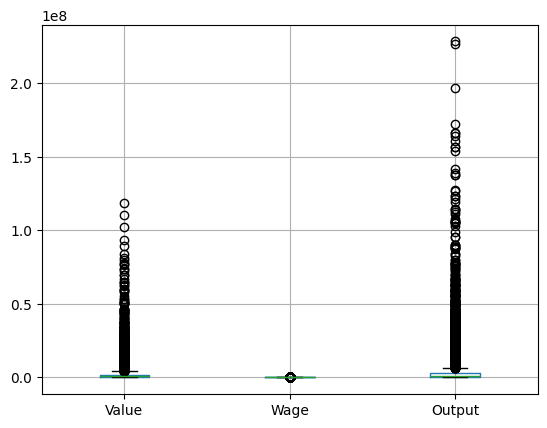

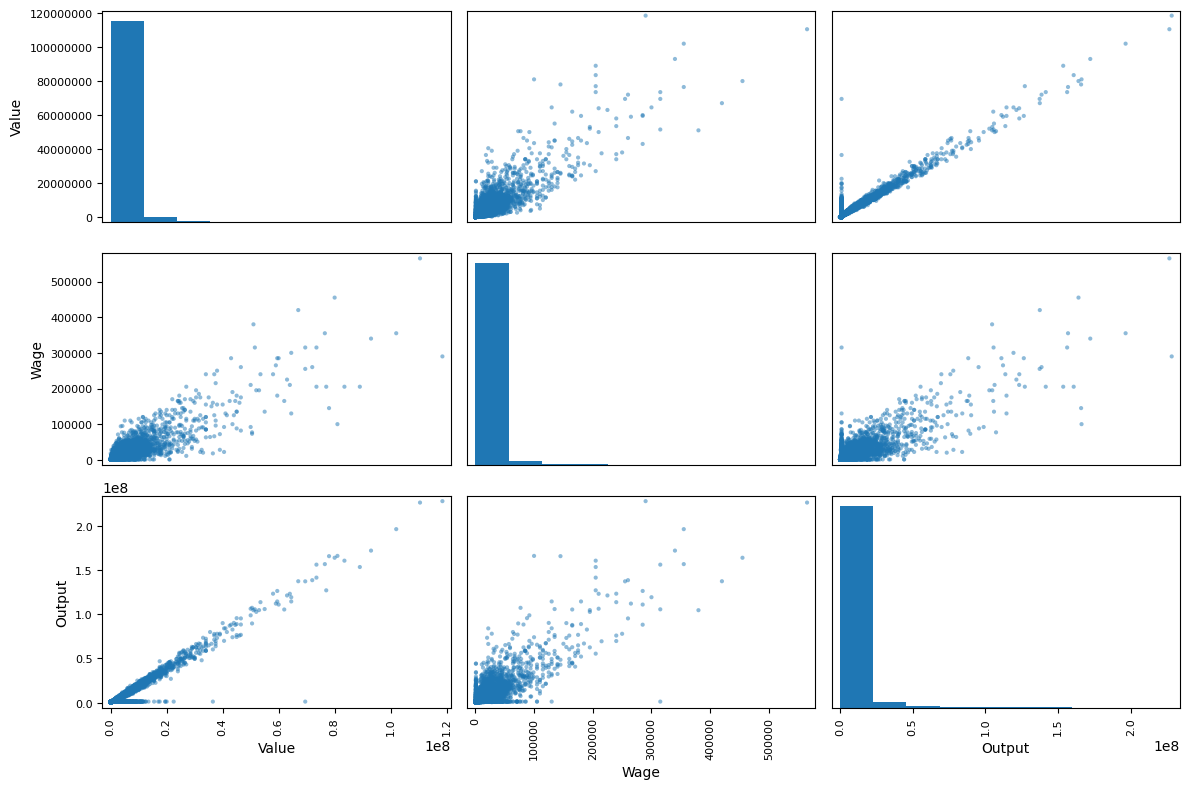

In [31]:
from pandas.plotting import scatter_matrix
Xm =pd.DataFrame(Xtrain_pre[['Value','Wage', 'International Reputation']],columns=['Value','Wage', 'International Reputation'])#definir pandas con atributos seleccionados
Xm['Output'] = ytrain_num #agregar salida
Xm.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

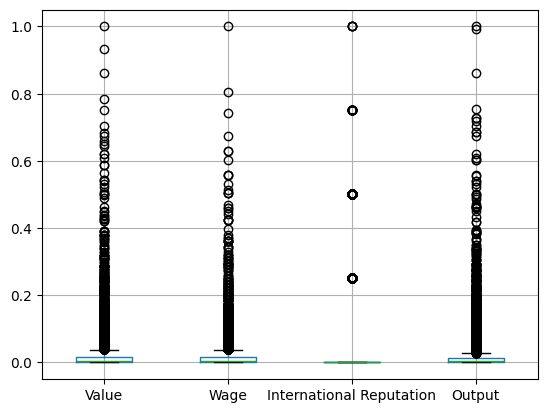

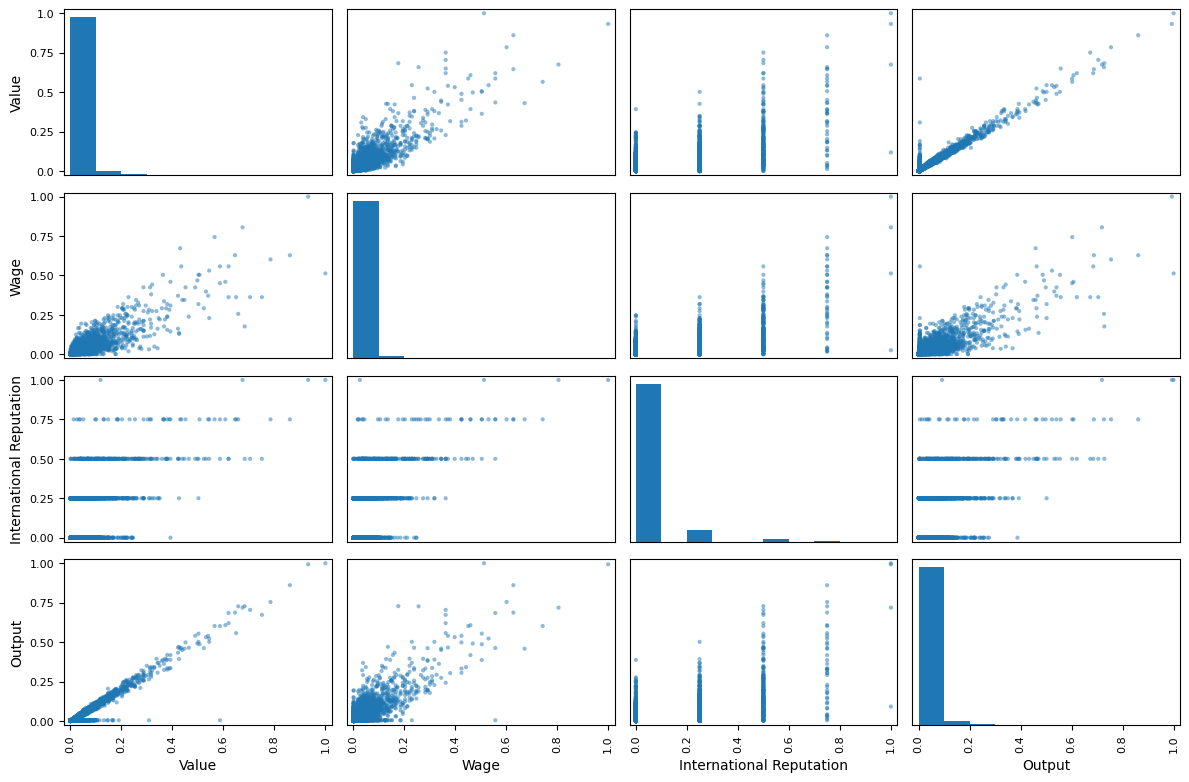

In [33]:
from sklearn.preprocessing import MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

Xm_pre_sca = pd.DataFrame(scaler.fit_transform(Xm),columns=Xm.columns)
Xm_pre_sca.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm_pre_sca, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()


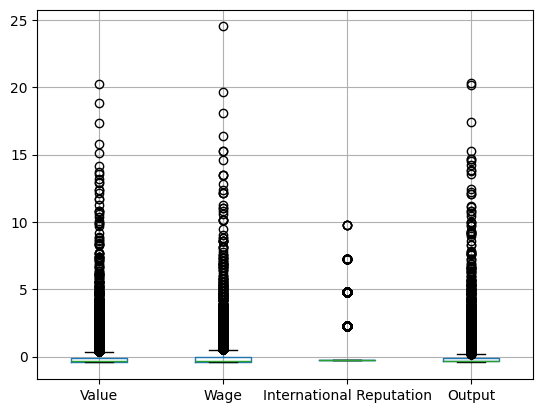

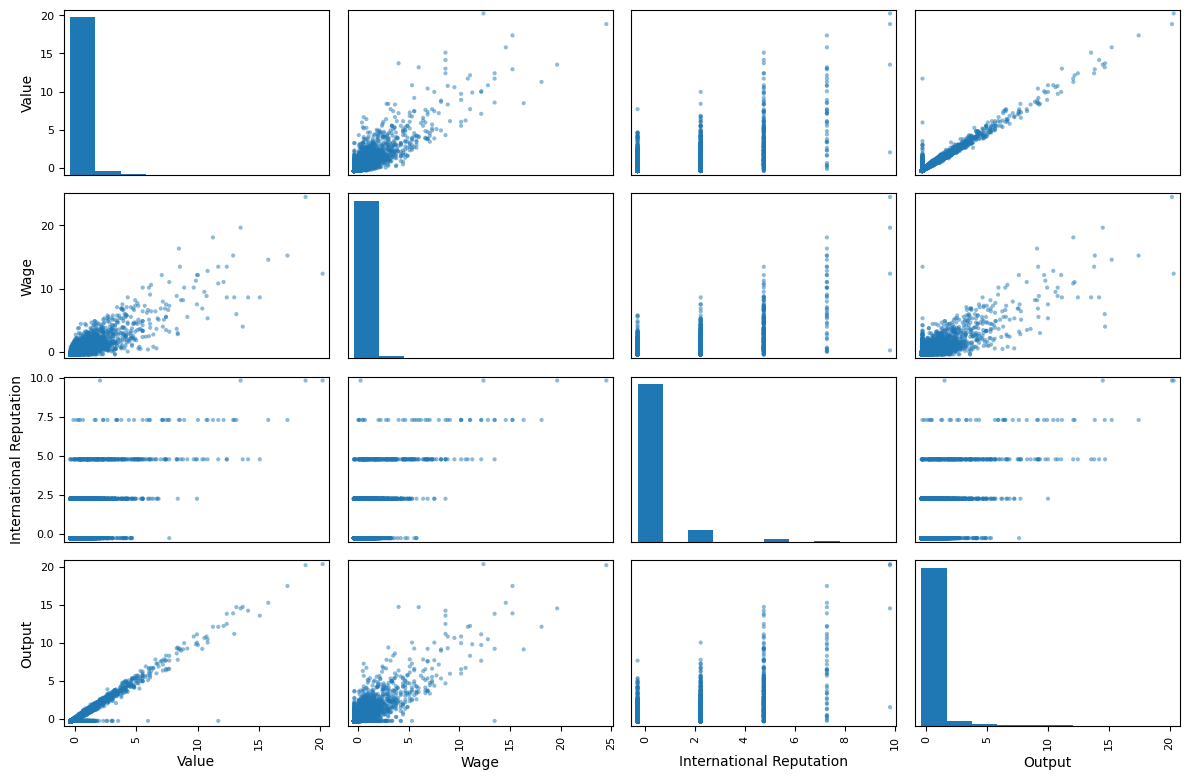

In [41]:
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
scaler = StandardScaler()

Xm_pre_sca = pd.DataFrame(scaler.fit_transform(Xm),columns=Xm.columns)
Xm_pre_sca.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm_pre_sca, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

# Se define pipeline para entrenar un modelo de regresión

**Nota:** Se sugiere utilizar un preproceso de normalización tipo StandardScaler o MinMaxScaler para evitar problemas de escala a la hora de identificar los patrones de interés.


A continuación se genera pipeline completo inlcuyendo preproceso custom, standardscaler y modelo de regresión lineal por mínimos cuadrados.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
steps = [('preproceso',mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
         ('scaler', StandardScaler()),
         ('regresion',LinearRegression())
         ]
metodo_full = Pipeline(steps=steps)
metodo_full.fit(Xtrain,ytrain_num) #entrena todos los pasos

Pipeline(steps=[('preproceso',
                 mypre_fifa(cat_usr={'Body Type': ['Normal', 'Lean', 'Stocky',
                                                   'Messi', 'C. Ronaldo',
                                                   'Neymar', 'Courtois',
                                                   'PLAYER_BODY_TYPE_25',
                                                   'Shaqiri', 'Akinfenwa'],
                                     'Club': ['FC Barcelona', 'Valencia CF',
                                              'Fortuna Düsseldorf',
                                              'Cardiff City', 'Rayo Vallecano',
                                              'CD Leganés', 'Frosinone',
                                              'Newcastle United', 'Southampton',
                                              'Burnley', 'Eintracht Frankfurt',
                                              'Wolve...
                                     'Work Rate': ['Medium/ Medium',
                                                   'High/ Medium',
                                                   'Medium/ High', 'High/ High',
                                                   'Medium/ Low', 'High/ Low',
                                                   'Low/ Medium', 'Low/ High',
                                                   'Low/ Low']},
                            col_euro=['Value', 'Wage'],
                            col_stats=['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF',
                                       'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
                                       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
                                       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB',
                                       'RB'])),
                ('scaler', StandardScaler()),
                ('regresion', LinearRegression())])

In [35]:
ytest_e = metodo_full.predict(Xtest) #se evalua el desempeño en el conjunto de test


Se grafican salida original y las predicciones

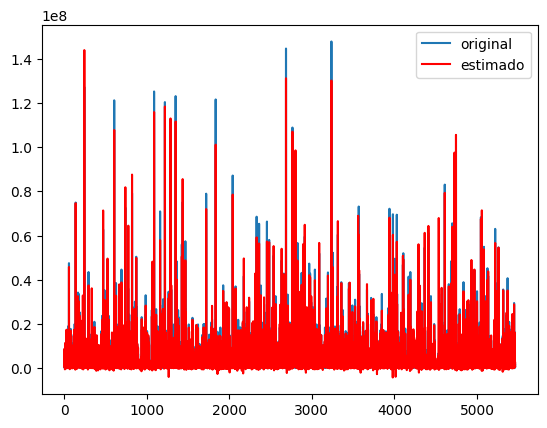

In [36]:
plt.plot(ytest_num,label='original')
plt.plot(ytest_e,'r',label='estimado')

plt.legend()
plt.show()

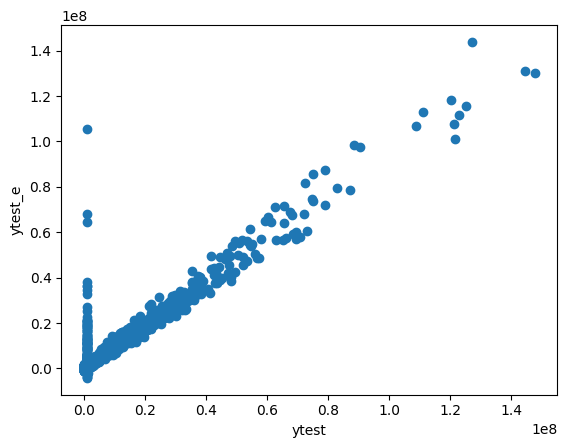

In [37]:
plt.scatter(ytest_num,ytest_e)
plt.xlabel('ytest')
plt.ylabel('ytest_e')
plt.show()

# Ejercicio 3

1. Utilizando el método steps del pipeline, realice una gráfica de las cargas (pesos) del modelo lineal entrenado. Qué puede discutir al respecto?

2. Consulte y presente el modelo y problema de optimización de los siguientes regresores:

 - [LinearRegresor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
 - [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
 - [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
 - [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
 - [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)
 - [BayesianRidge](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression)
 - [Gaussian Process Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)

3. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento preprocesado, compare el rendimiento en el conjunto de test de los regresores del punto 2. fijando el score del [gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) en términos del error absoluto medio y el error cuádratico medio. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 2. Para el caso del kernelRidge y GPR se sugiere trabajar sobre un conjunto de train de 5000 puntos para evitar problemas de memoría en los cálculos de la matriz kernel (presente los resultados para kernel ridge utilizando una función rbf).



## SOLUCIÓN EJERCICIO 3

grafica de pesos del modelo

In [38]:
# Acceder al modelo de regresión lineal dentro del pipeline
modelo = metodo_full.named_steps['regresion']

# Obtener los coeficientes (pesos) del modelo
coeficientes = modelo.coef_

# Si tienes un intercepto, también puedes acceder a él
intercepto = modelo.intercept_

print("Coeficientes del modelo:", coeficientes)
print("Intercepto del modelo:", intercepto)

Coeficientes del modelo: [ 2.84180621e+05  8.65824408e+04 -5.91429255e+05  2.63360103e+05
 -1.39506315e+05  1.11967011e+07 -1.82316871e+05  6.98989299e+05
 -5.02773636e+04 -1.66594427e+05 -4.33143702e+04 -1.49340015e+05
  2.49191925e+04  3.94112815e+04  5.04084413e+04 -7.74840240e+04
 -5.60310470e+04  1.02735325e+05 -3.40306407e+05 -6.35911150e+03
 -9.40970712e+04 -2.02229180e+18  9.51430515e+17  1.07086129e+18
  7.06354207e+17  1.48087104e+16 -8.04663395e+16  6.56576291e+16
 -7.06354207e+17 -1.60587126e+17  7.00366359e+16  9.05504904e+16
 -1.72993034e+17  3.17223605e+17 -1.40549184e+17 -1.76674421e+17
  1.72993034e+17  9.20198100e+17 -2.72446657e+17 -6.87966226e+16
  3.41243279e+17 -9.20198100e+17 -5.37273808e+17  7.95597797e+17
 -1.38553934e+18  5.89941543e+17  5.37273808e+17  1.22816000e+05
  1.46176000e+05 -5.98400000e+04  2.34240000e+04 -2.69728000e+05
  3.34560000e+04  5.76000000e+04 -1.60064000e+05 -1.73320000e+04
 -5.99040000e+04 -1.72800000e+04  6.19520000e+04 -6.80320000e+04


In [39]:
# Supongamos que Xtrain tiene nombres de columnas (puedes usar el nombre de las columnas de Xtrain)
nombres_columnas = Xtrain.columns

# Crear un DataFrame con los coeficientes y sus nombres correspondientes
coeficientes_df = pd.DataFrame(coeficientes, index=nombres_columnas, columns=['Coeficiente'])
print(coeficientes_df)

                 Coeficiente
Age            284180.621135
Nationality     86582.440758
Overall       -591429.254898
Potential      263360.103262
Club          -139506.315451
...                      ...
GKDiving      -261888.000000
GKHandling      49984.000000
GKKicking      -28480.000000
GKPositioning  178944.000000
GKReflexes      -3968.000000

[81 rows x 1 columns]


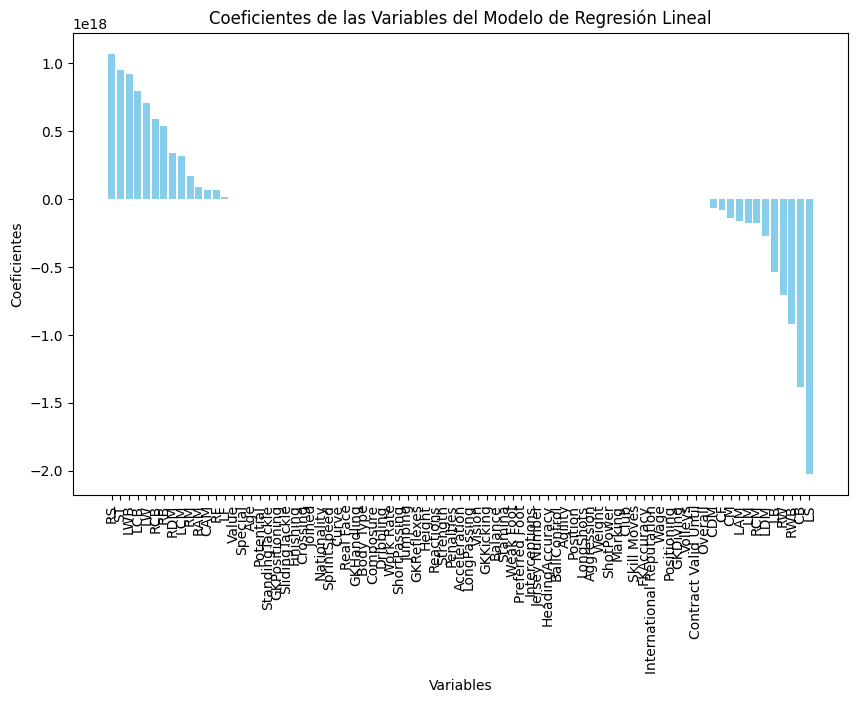

In [40]:
# Acceder al modelo de regresión lineal dentro del pipeline
modelo = metodo_full.named_steps['regresion']

# Obtener los coeficientes del modelo
coeficientes = modelo.coef_

# Supongamos que Xtrain tiene nombres de columnas
nombres_columnas = Xtrain.columns

# Crear un DataFrame con los coeficientes y sus nombres correspondientes
coeficientes_df = pd.DataFrame(coeficientes, index=nombres_columnas, columns=['Coeficiente'])

# Ordenar los coeficientes para una mejor visualización (opcional)
coeficientes_df = coeficientes_df.sort_values(by='Coeficiente', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(coeficientes_df.index, coeficientes_df['Coeficiente'], color='skyblue')
plt.title('Coeficientes de las Variables del Modelo de Regresión Lineal')
plt.xlabel('Variables')
plt.ylabel('Coeficientes')
plt.xticks(rotation=90)  # Rotar los nombres de las variables para una mejor lectura
plt.show()

In [ ]:
#Ayuda punto 2 y 3
#Dado que el preproceso no cambia, se sugiera generar el pipeline sin mypre_fifa para ahorrar tiempo
steps = [('scaler', StandardScaler()), #ajustar según ejercicio
         ('regresion',LinearRegression()) #ajustar según ejercicio
         ]
metodo_gs = Pipeline(steps=steps) #pipeline a utilizar en el gridsearch
#Recuerde realizar el fit del gridsearch sobre las matrices de entrada y vector de salida preprocesados
#Xtrain_pre ytrain_num


PUNTO 2

Consulte y presente el modelo y problema de optimización

## 1. **Linear Regression (Regresión Lineal)**

- **Modelo**: La regresión lineal ajusta una línea (o un plano en dimensiones mayores) para predecir una variable dependiente \(y\) a partir de una o más variables independientes \(X\). El modelo tiene la forma:
$$
  y = X\beta + \epsilon
$$
  donde $$(y)$$ es la variable dependiente,$$(X)$$ es la matriz de características, $$(\beta)$$ son los coeficientes que se aprenden y $$(\epsilon)$$ es el error (ruido).
  
- **Problema de Optimización**: El objetivo de la regresión lineal es minimizar la suma de los errores cuadráticos (o la "función de costo" o **MSE**):
 $$
  \text{minimizar} \ \|y - X\beta\|^2
 $$
  Esto implica encontrar los valores óptimos para los coeficientes $$(\beta)$$ que mejor ajusten la recta a los datos.

## 2. **Lasso (Least Absolute Shrinkage and Selection Operator)**

- **Modelo**: Lasso es una variación de la regresión lineal que incorpora regularización **L1** (norma L1) para reducir el sobreajuste y seleccionar características. El modelo tiene la misma forma que la regresión lineal, pero con una penalización adicional:
  $$
  \text{minimizar} \ \|y - X\beta\|^2 + \lambda \|\beta\|_1
 $$
  donde $$(\lambda)$$ es el parámetro de regularización que controla el grado de penalización.
  
- **Problema de Optimización**: Lasso minimiza la función de error cuadrático con una penalización basada en la norma L1 de los coeficientes, lo que puede resultar en coeficientes exactamente cero para algunas características. Esto realiza una selección automática de características.

## 3. **Kernel Ridge Regression**

- **Modelo**: La regresión Ridge tradicional (usada en la regresión lineal) utiliza la penalización L2 para evitar el sobreajuste. En Kernel Ridge, se utiliza un *kernel* para transformar las características originales en un espacio de mayor dimensión, permitiendo modelar relaciones no lineales.
  
- **Problema de Optimización**: El modelo de Kernel Ridge tiene la forma:
  $$
  \text{minimizar} \ \|y - K\beta\|^2 + \lambda \|\beta\|_2^2
  $$
  donde $$(K)$$ es la matriz de kernel (similar a un producto punto no lineal), y $$(\lambda)$$ es el parámetro de regularización.

---

## 4. **ElasticNet**

- **Modelo**: ElasticNet es una combinación de la regresión Lasso (L1) y la regresión Ridge (L2). Su objetivo es combinar lo mejor de ambos métodos para obtener una regularización más flexible.
  
- **Problema de Optimización**: ElasticNet utiliza una combinación de penalizaciones L1 y L2:
  $$
  \text{minimizar} \ \|y - X\beta\|^2 + \lambda_1 \|\beta\|_1 + \lambda_2 \|\beta\|_2^2
  $$
  donde $$(\lambda_1)$$ y $$(\lambda_2)$$ son los parámetros de regularización que controlan las contribuciones de la regularización L1 y L2.

---

## 5. **SGDRegressor (Stochastic Gradient Descent)**

- **Modelo**: El SGDRegressor es una implementación de la regresión lineal que utiliza el algoritmo de optimización de descenso de gradiente estocástico. A diferencia de la regresión lineal convencional, donde la solución se obtiene por la fórmula cerrada, el SGDRegressor actualiza los coeficientes iterativamente, utilizando pequeños lotes de datos para actualizar las predicciones.
  
- **Problema de Optimización**: El problema de optimización es similar al de la regresión lineal, pero con una penalización opcional L2 (Ridge):
  $$
  \text{minimizar} \ \frac{1}{N} \sum_{i=1}^{N} (y_i - \mathbf{x}_i^T \beta)^2 + \lambda \|\beta\|_2^2
  $$
  donde $$(N)$$ es el número de muestras, $$(\lambda)$$ es la regularización L2 y $$(\beta)$$ son los coeficientes del modelo.

---

## 6. **Bayesian Ridge Regression**

- **Modelo**: La regresión Ridge bayesiana es un modelo probabilístico que supone que los coeficientes del modelo siguen una distribución gaussiana. La regresión bayesiana ajusta los coeficientes de manera probabilística, considerando tanto los datos como la incertidumbre en los coeficientes.
  
- **Problema de Optimización**: El modelo busca maximizar la verosimilitud de los datos dada la distribución de los coeficientes. El problema de optimización es:
   $$
  \text{maximizar} \ P(y | X, \beta, \sigma^2) \times P(\beta | \lambda)
   $$
  donde  $$(P(\beta | \lambda) ) $$ es la distribución a priori de los coeficientes.

---

## 7. **Gaussian Process Regressor**

- **Modelo**: El regresor de procesos gaussianos (GPR) es un modelo no paramétrico que predice distribuciones de probabilidad sobre las funciones. Es un enfoque basado en la teoría de procesos estocásticos y se utiliza para realizar inferencia sobre funciones desconocidas en el contexto de regresión.
  
- **Problema de Optimización**: GPR optimiza la función de verosimilitud marginal de los datos, lo que implica calcular la covarianza entre los puntos de datos y ajustar la matriz de covarianzas $$(K)$$ para obtener la mejor predicción.

---

## Resumen del Tipo de Optimización:

| **Regresor**                  | **Problema de Optimización**                                                             |
|-------------------------------|------------------------------------------------------------------------------------------|
| **Linear Regression**          | Minimizar la suma de los errores cuadráticos.                                            |
| **Lasso**                      | Minimizar la suma de los errores cuadráticos más una penalización L1 en los coeficientes.|
| **ElasticNet**                 | Minimizar la suma de los errores cuadráticos más una combinación de penalización L1 y L2. |
| **Kernel Ridge**               | Minimizar los errores cuadráticos con una penalización L2 usando un kernel no lineal.    |
| **SGDRegressor**               | Optimización iterativa usando el descenso de gradiente, con penalización L2 opcional.     |
| **Bayesian Ridge**             | Maximizar la verosimilitud marginal considerando distribuciones a priori sobre los coeficientes. |
| **Gaussian Process Regressor** | Optimizar la función de verosimilitud marginal de los procesos gaussianos.                |

## EJERCICIO 3

Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento preprocesado, compare el rendimiento en el conjunto de test de los regresores del punto 2. fijando el score del gridsearch en términos del error absoluto medio y el error cuádratico medio. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 2. Para el caso del kernelRidge y GPR se sugiere trabajar sobre un conjunto de train de 5000 puntos para evitar problemas de memoría en los cálculos de la matriz kernel (presente los resultados para kernel ridge utilizando una función rbf).

## IMPORTAMOS LIBRERIAS

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

## MATRIZ DE MODELOS

In [62]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'KernelRidge': KernelRidge(kernel='rbf'),  # Usamos un kernel RBF como se sugiere
    'SGDRegressor': SGDRegressor(),
    'BayesianRidge': BayesianRidge(),
    'GaussianProcessRegressor': GaussianProcessRegressor()
}

## MATRIZ DE HYPERPARAMETROS PARA VARIAR

In [63]:
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
param_grids = {
    'Linear Regression': {},
    'Lasso': {'alpha': [0.01, 0.1, 1, 10]},  # Regresión Lasso: regularización (alpha)
    'ElasticNet': {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]},  # ElasticNet: L1 y L2
    'KernelRidge': {'alpha': [1, 0.1, 0.01], 'gamma': [0.1, 1, 10]},  # Kernel Ridge: regularización y parámetro gamma
    'SGDRegressor': {'alpha': [0.01, 0.1, 1, 10], 'max_iter': [1000, 2000]},  # SGDRegressor: regularización y iteraciones
    'BayesianRidge': {'alpha_1': [1e-6, 1e-3, 1e-1], 'alpha_2': [1e-6, 1e-3, 1e-1]},  # BayesianRidge: hiperparámetros de regularización
    'GaussianProcessRegressor': {'alpha': [1e-6, 1e-3, 1e-1], 'kernel': [RBF()]}  # GPR: kernel y alpha
}

## FUNCIÓN PARA EVALUAR LOS MODELOS

In [64]:
def evaluate_model(model, X_train, y_train, param_grid, cv=5):
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=cv)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return best_model, best_params, best_score


## DEFINIMOS EL ESQUEMA DE DATOS

In [65]:
Xtrain.shape,ytrain.shape

((12744, 81), (12744,))

In [66]:
Xtrain

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
8494,24,France,67,75,Valenciennes FC,€975K,€2K,1444,Right,1.0,...,50.0,57.0,70.0,71.0,68.0,12.0,11.0,12.0,15.0,7.0
13175,30,England,62,62,Swindon Town,€290K,€3K,1548,Right,1.0,...,46.0,50.0,29.0,31.0,32.0,9.0,8.0,9.0,15.0,10.0
10403,20,Spain,65,76,Udinese,€925K,€5K,1633,Right,1.0,...,58.0,68.0,62.0,43.0,48.0,12.0,10.0,12.0,8.0,8.0
10992,24,Japan,64,70,Kashima Antlers,€625K,€3K,1675,Right,1.0,...,63.0,60.0,36.0,22.0,33.0,10.0,13.0,13.0,7.0,10.0
4032,29,France,71,71,En Avant de Guingamp,€1.8M,€14K,2026,Left,1.0,...,73.0,70.0,66.0,71.0,72.0,15.0,13.0,14.0,11.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14125,29,Saudi Arabia,61,61,Al Hazem,€200K,€2K,1553,Left,1.0,...,47.0,46.0,58.0,61.0,59.0,7.0,12.0,15.0,15.0,9.0
1689,25,Cameroon,75,76,VfL Wolfsburg,€8M,€36K,1841,Right,2.0,...,68.0,68.0,32.0,25.0,15.0,15.0,9.0,9.0,8.0,6.0
17277,20,Norway,55,65,Ranheim Fotball,€140K,€1K,1496,Right,1.0,...,38.0,42.0,53.0,56.0,51.0,15.0,8.0,6.0,12.0,14.0
12326,21,Poland,63,72,Górnik Zabrze,€575K,€1K,1663,Right,1.0,...,53.0,58.0,33.0,33.0,34.0,12.0,8.0,12.0,13.0,12.0


## ESQUEMA PARA ENTRENAR EL MODELO

In [67]:
results = {}
for model_name, model in models.items():
    print(f"Evaluando {model_name}...")
    best_model, best_params, best_score = evaluate_model(model,Xtrain_pre, ytrain_num, param_grids[model_name])
    results[model_name] = {
        'Best Model': best_model,
        'Best Params': best_params,
        'Best MAE Score': -best_score
    }

for model_name, result in results.items():
    print(f"\nModelo: {model_name}")
    print(f"Mejor modelo: {result['Best Model']}")
    print(f"Mejores hiperparámetros: {result['Best Params']}")
    print(f"Mejor puntuación MAE (error absoluto medio): {result['Best MAE Score']:.4f}")

    y_pred = result['Best Model'].predict(Xtest_pre)
    rmse = np.sqrt(mean_squared_error(ytest_num, y_pred))
    print(f"RMSE (error cuadrático medio) en test: {rmse:.4f}")

Evaluando Linear Regression...
Evaluando Lasso...
Evaluando ElasticNet...
Evaluando KernelRidge...
Evaluando SGDRegressor...
Evaluando BayesianRidge...
Evaluando GaussianProcessRegressor...

Modelo: Linear Regression
Mejor modelo: LinearRegression()
Mejores hiperparámetros: {}
Mejor puntuación MAE (error absoluto medio): 868942.9851
RMSE (error cuadrático medio) en test: 2929373.1151

Modelo: Lasso
Mejor modelo: Lasso(alpha=10)
Mejores hiperparámetros: {'alpha': 10}
Mejor puntuación MAE (error absoluto medio): 867498.4758
RMSE (error cuadrático medio) en test: 2929667.3724

Modelo: ElasticNet
Mejor modelo: ElasticNet(alpha=10, l1_ratio=0.1)
Mejores hiperparámetros: {'alpha': 10, 'l1_ratio': 0.1}
Mejor puntuación MAE (error absoluto medio): 809423.4800
RMSE (error cuadrático medio) en test: 2948823.9500

Modelo: KernelRidge
Mejor modelo: KernelRidge(gamma=0.1, kernel='rbf')
Mejores hiperparámetros: {'alpha': 1, 'gamma': 0.1}
Mejor puntuación MAE (error absoluto medio): 4332898.4269
RMSE

In [68]:
results

{'Linear Regression': {'Best Model': LinearRegression(),
  'Best Params': {},
  'Best MAE Score': 868942.9851073173},
 'Lasso': {'Best Model': Lasso(alpha=10),
  'Best Params': {'alpha': 10},
  'Best MAE Score': 867498.4758425734},
 'ElasticNet': {'Best Model': ElasticNet(alpha=10, l1_ratio=0.1),
  'Best Params': {'alpha': 10, 'l1_ratio': 0.1},
  'Best MAE Score': 809423.4799893455},
 'KernelRidge': {'Best Model': KernelRidge(gamma=0.1, kernel='rbf'),
  'Best Params': {'alpha': 1, 'gamma': 0.1},
  'Best MAE Score': 4332898.4269079575},
 'SGDRegressor': {'Best Model': SGDRegressor(alpha=0.01, max_iter=2000),
  'Best Params': {'alpha': 0.01, 'max_iter': 2000},
  'Best MAE Score': 6.228381189980085e+21},
 'BayesianRidge': {'Best Model': BayesianRidge(),
  'Best Params': {'alpha_1': 1e-06, 'alpha_2': 1e-06},
  'Best MAE Score': 785844.8640960793},
 'GaussianProcessRegressor': {'Best Model': GaussianProcessRegressor(alpha=1e-06, kernel=RBF(length_scale=1)),
  'Best Params': {'alpha': 1e-06,